In [1]:
%matplotlib inline

from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import joblib
import re

# Gensim
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'said','rsquo','euro','&#39;','...','..','39',"'s",
 '....',
 '10',
 '15',
 '20',
 '30','acirc',"n't",'n/a']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

C:\Users\ADMIN\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('white')
plt.rcParams['figure.figsize'] = (14.0, 8.7)

In [4]:
pyLDAvis.enable_notebook()

In [5]:
data_ov = pd.read_csv(r'Negative_data.csv')

In [6]:
data_ov.shape

(2350, 4)

In [7]:
data_ov.head()

REVIEW_ID           MEMBER_ID  \
0  a2p1U000000Ro7KQAS  0011U00000rjF6eQAE   
1  a2p3g000000L0RrAAK  0011U00000riHDHQA2   
2  a2p1U000000RoGYQA0  0011U00000rjxhBQAQ   
3  a2p1U000000Rot5QAC  0011U00000rk4ksQAA   
4  a2p1U000000Ro5gQAC  0011U00000ri0GGQAY   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Reviews  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              everything    dr gray listened and offered feedback i never felt rushed i had an awesome appt  thank youvant think of anything   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 friendly and professional staff clean and calm waiting room   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     i love that my doctor spends time with me and follows up on things we talked about during my last appointment  i never feel rushed  which is why i left my last doctor    
3  went in to have eye checked for possible corneal abrasion    when they got the kit to check  they realized they did not have the stain necessary to do

In [8]:
data_ov['Reviews'].isnull().sum()

0

### Negative comments on reviews

In [9]:
docs = data_ov
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   REVIEW_ID        2350 non-null   object
 1   MEMBER_ID        2350 non-null   object
 2   Reviews          2350 non-null   object
 3   sentiment_label  2350 non-null   object
dtypes: object(4)
memory usage: 73.6+ KB


## training model

In [10]:
X_train, X_hold = train_test_split(docs, test_size=0.2, random_state=111)

In [11]:
X_train.head()

REVIEW_ID           MEMBER_ID  \
1176  a2p4w000002OCgXAAW  0011U00000riD6vQAE   
146   a2p1U000000RoBXQA0  0011U00000rjXS6QAM   
841   a2p1U000000RoB1QAK  0011U00000riYG0QAM   
2017  a2p4w000002O4n1AAC  0011U00000riu8GQAQ   
1089  a2p4w000002OAXYAA4  0014w00003GEdNPAA1   

                                                                                                                                                                                                                                                                                   Reviews  \
1176                                                                                                                                                                                               dr  black provided relevant and helpful information in a professional and caring manner   
146   i am not getting the services that i need and i don     t get any follow up from my doctorsent the referral but the medical assistant had a attitude my visit was not very good i didn     t feel like i was treated with respect  i felt like i was just a number and not a person    
841                                                                                                      the assistant was very friendly and the nurse practitioner  katie  was very thorough with a very good bedside mannereverything went well   there was nothing that did not go well   
2017                                                                                                                                                       very easy to talk to  don rsquo t feel like they need to move on to the next patient before i feel i rsquo m donemegan listens    
1089                                                good clinic  but it seems they need more help  quality care  they need more staff quality care at exam it was a previous appointment that had impact on this appointment  poor follow up of a referral that never would have happened    

     sentiment_label  
1176        Negative  
146         Negative  
841         Negative  
2017        Negative  
1089        Negative

In [12]:
X_train['Reviews'] = X_train['Reviews'].astype(str)

In [13]:
from nltk.stem import WordNetLemmatizer
import nltk
lemma = WordNetLemmatizer()

In [14]:
def tokenize(text):
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 2) ] 
   lem = [lemma.lemmatize(item) for item in tokens]
   return tokens

In [15]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=stop_words, max_df=0.50, min_df=2, max_features=10000, use_idf=True, norm='l2',ngram_range=(1,3))
tf_vectors = vectorizer_tf.fit_transform(X_train.Reviews)

In [16]:
tf_vectors.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
vectorizer_tf.get_feature_names()

['ability',
 'able',
 'able address',
 'able answer',
 'able answer questions',
 'able appointment',
 'able ask',
 'able blood',
 'able care',
 'able connect',
 'able day',
 'able day appointment',
 'able discuss',
 'able doctor',
 'able draw',
 'able draw blood',
 'able help',
 'able listen',
 'able make',
 'able make appointment',
 'able medication',
 'able open',
 'able prescribe',
 'able provide',
 'able quickly',
 'able right',
 'able right staff',
 'able schedule',
 'able schedule appointment',
 'able schedule online',
 'able seen',
 'able spend',
 'able time',
 'able work',
 'abrasive',
 'absolute',
 'absolute best',
 'absolutely',
 'absolutely love',
 'absolutely love time',
 'absolutely visit',
 'absolutely visit don',
 'absolutely wonderful',
 'acceptable',
 'accepted',
 'access',
 'access doctors',
 'access medical',
 'access medical records',
 'access portal',
 'access virtual',
 'accessible',
 'accident',
 'accommodate',
 'accommodated',
 'accommodating',
 'accompanied',
 

In [18]:
from sklearn import decomposition
lda = decomposition.LatentDirichletAllocation()

W1 = lda.fit_transform(tf_vectors)
H1 = lda.components_

In [19]:
-(np.log(lda.perplexity(tf_vectors)))

-11.102974712144936

In [20]:
print("Log Likelihood: ", lda.score(tf_vectors))

Log Likelihood:  -88656.39814112283


In [21]:
print("Perplexity: ", lda.perplexity(tf_vectors))

Perplexity:  66368.29338409164


In [22]:
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [5,6,7,8], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf_vectors)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 6, 7, 8]})

In [23]:
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}


In [24]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0), n_jobs=1,
       param_grid={'n_topics': [5,8,10], 'learning_decay': [0.1,0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.1, 0.5, 0.7, 0.9],
                         'n_topics': [5, 8, 10]},
             return_train_score='warn')

In [25]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf_vectors))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -21460.511400929867
Model Perplexity:  19131.97654799454


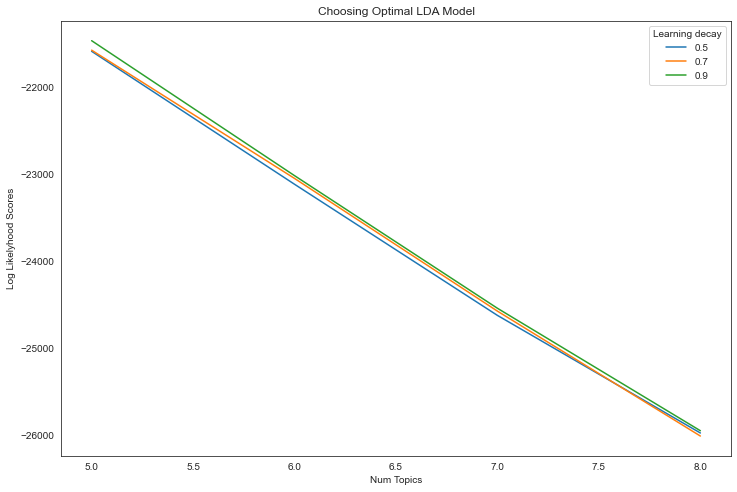

In [26]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5,6,7,8]

log_likelyhoods_1 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_3 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))

plt.plot(n_topics, log_likelyhoods_1, label='0.5')
plt.plot(n_topics, log_likelyhoods_3, label='0.7')
plt.plot(n_topics, log_likelyhoods_5, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [27]:
n_topics = 5

In [28]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(tf_vectors)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(X_train['Reviews']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [29]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

Topic Num  Num Documents
0          1            678
1          0            402
2          3            307
3          2            299
4          4            194

In [30]:
H1 = best_lda_model.components_
W1 = best_lda_model.fit_transform(tf_vectors)

In [31]:
num_words=15

vocab = np.array(vectorizer_tf.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [32]:
topics

['time doctor staff didn blood appointment waiting rushed took questions listen feel friendly wait concerns',
 'appointment time staff doctor office phone care called did visit waiting feel issues told don',
 'time doctor waiting appointment concerns listened questions staff took friendly felt did great feel good',
 'doctor time rushed issues great staff waiting feel friendly appointment felt listened good professional blood',
 'time appointment doctor good felt need work feel questions friendly thorough phone visit did staff']

In [33]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf_vectors, vectorizer_tf, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  30.420084
1       51.163364 -159.968018       2        1  29.541473
4      -73.144554   21.523815       3        1  19.778565
3      -66.410133 -110.606438       4        1  11.862851
2       54.417324   12.443444       5        1   8.397028, topic_info=                             Term       Freq      Total Category  logprob  \
4568                      service   8.000000   8.000000  Default  30.0000   
3750                        phone  12.000000  12.000000  Default  29.0000   
89                      addressed   5.000000   5.000000  Default  28.0000   
4399                         rude   4.000000   4.000000  Default  27.0000   
736                        caring  11.000000  11.000000  Default  26.0000   
2954                     listened  12.000000  12.000000  Default  25.0000   
2632             issues addressed   1.000000   1.000000  Default  24.0000   
2631                       issues  17.000000  17.000000  Default  23.0000   
1572                         draw   7.000000   7.000000  Default  22.0000   
558                         black   7.000000   7.000000  Default  21.0000   
4407                       rushed  16.000000  16.000000  Default  20.0000   
2995                       little   7.000000   7.000000  Default  19.0000   
319                  appointments   7.000000   7.000000  Default  18.0000   
1080                        covid   6.000000   6.000000  Default  17.0000   
349                          appt   9.000000   9.000000  Default  16.0000   
1862                         fast   3.000000   3.000000  Default  15.0000   
926                      concerns  14.000000  14.000000  Default  14.0000   
4767                        staff  24.000000  24.000000  Default  13.0000   
1748                    excellent   6.000000   6.000000  Default  12.0000   
2800                knowledgeable   6.000000   6.000000  Default  11.0000   
1916                  feel rushed   7.000000   7.000000  Default  10.0000   
456                     attentive   6.000000   6.000000  Default   9.0000   
1574                   draw blood   3.000000   3.000000  Default   8.0000   
3067                         love   7.000000   7.000000  Default   7.0000   
2205                         good  17.000000  17.000000  Default   6.0000   
4371                         room  11.000000  11.000000  Default   5.0000   
2236                 good service   1.000000   1.000000  Default   4.0000   
4606                         shot   4.000000   4.000000  Default   3.0000   
4517                        scott   1.000000   1.000000  Default   2.0000   
1327                    difficult   9.000000   9.000000  Default   1.0000   
1574                   draw blood   3.283554   3.930206   Topic1  -6.6063   
1578                      drawing   1.990718   2.404054   Topic1  -7.1067   
1579                drawing blood   1.938924   2.352333   Topic1  -7.1331   
3339                    need know   1.959052   2.485013   Topic1  -7.1228   
5243                    time need   1.445736   1.857487   Topic1  -7.4266   
15                able draw blood   1.333501   1.746077   Topic1  -7.5074   
14                      able draw   1.333501   1.746077   Topic1  -7.5074   
5682                  waited long   1.240475   1.652237   Topic1  -7.5797   
4679                     solution   1.226180   1.638635   Topic1  -7.5913   
456                     attentive   4.791130   6.490427   Topic1  -6.2285   
1572                         draw   5.814133   7.916422   Topic1  -6.0350   
5171                    time didn   1.078651   1.494262   Topic1  -7.7195   
4609                        shots   1.301796   1.804129   Topic1  -7.5315   
296              appointment tell   1.034296   1.446046   Topic1  -7.7615   
1680                        enjoy   1.440915   2.025008   Topic1  -7.4300   
585      

In [34]:
colnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_train.Reviews))]
df_doc_topic = pd.DataFrame(np.round(W1, 3), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic

In [35]:
X_train.head()

REVIEW_ID           MEMBER_ID  \
1176  a2p4w000002OCgXAAW  0011U00000riD6vQAE   
146   a2p1U000000RoBXQA0  0011U00000rjXS6QAM   
841   a2p1U000000RoB1QAK  0011U00000riYG0QAM   
2017  a2p4w000002O4n1AAC  0011U00000riu8GQAQ   
1089  a2p4w000002OAXYAA4  0014w00003GEdNPAA1   

                                                                                                                                                                                                                                                                                   Reviews  \
1176                                                                                                                                                                                               dr  black provided relevant and helpful information in a professional and caring manner   
146   i am not getting the services that i need and i don     t get any follow up from my doctorsent the referral but the medical assistant had a attitude my visit was not very good i didn     t feel like i was treated with respect  i felt like i was just a number and not a person    
841                                                                                                      the assistant was very friendly and the nurse practitioner  katie  was very thorough with a very good bedside mannereverything went well   there was nothing that did not go well   
2017                                                                                                                                                       very easy to talk to  don rsquo t feel like they need to move on to the next patient before i feel i rsquo m donemegan listens    
1089                                                good clinic  but it seems they need more help  quality care  they need more staff quality care at exam it was a previous appointment that had impact on this appointment  poor follow up of a referral that never would have happened    

     sentiment_label  
1176        Negative  
146         Negative  
841         Negative  
2017        Negative  
1089        Negative

In [36]:
df_doc_topic.head()

Topic0  Topic1  Topic2  Topic3  Topic4  dominant_topic
Doc0   0.050   0.800   0.049   0.050   0.050               1
Doc1   0.033   0.623   0.278   0.033   0.033               1
Doc2   0.827   0.044   0.043   0.043   0.043               0
Doc3   0.049   0.805   0.048   0.048   0.049               1
Doc4   0.041   0.838   0.040   0.040   0.041               1

In [37]:
df_doc_topic['dominant_topic'].value_counts()

0    597
1    573
4    368
3    211
2    131
Name: dominant_topic, dtype: int64

## Testing model

In [38]:
WHold = best_lda_model.transform(vectorizer_tf.transform(X_hold.Reviews))

In [39]:
colnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_hold.Reviews))]
df_doc_topic = pd.DataFrame(np.round(WHold, 3), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic


In [40]:
df_doc_topic['dominant_topic'].value_counts()

0    205
1    184
4     69
3     11
2      1
Name: dominant_topic, dtype: int64

In [41]:
df_doc_topic

Topic0  Topic1  Topic2  Topic3  Topic4  dominant_topic
Doc0     0.053   0.052   0.051   0.053   0.791               4
Doc1     0.053   0.054   0.053   0.052   0.789               4
Doc2     0.170   0.195   0.048   0.041   0.546               4
Doc3     0.822   0.043   0.044   0.048   0.043               0
Doc4     0.529   0.339   0.062   0.035   0.036               0
Doc5     0.860   0.036   0.034   0.034   0.035               0
Doc6     0.200   0.200   0.200   0.200   0.200               0
Doc7     0.738   0.065   0.064   0.068   0.065               0
Doc8     0.056   0.780   0.055   0.055   0.055               1
Doc9     0.033   0.718   0.033   0.033   0.183               1
Doc10    0.648   0.027   0.026   0.031   0.268               0
Doc11    0.686   0.233   0.027   0.026   0.027               0
Doc12    0.077   0.692   0.076   0.076   0.079               1
Doc13    0.539   0.388   0.024   0.024   0.025               0
Doc14    0.450   0.389   0.054   0.053   0.054               0
Doc15    0.655   0.048   0.050   0.197   0.049               0
Doc16    0.811   0.047   0.046   0.048   0.048               0
Doc17    0.338   0.044   0.044   0.044   0.530               4
Doc18    0.473   0.399   0.042   0.043   0.043               0
Doc19    0.073   0.072   0.069   0.717   0.069               3
Doc20    0.038   0.843   0.038   0.041   0.039               1
Doc21    0.130   0.747   0.041   0.041   0.041               1
Doc22    0.065   0.743   0.063   0.065   0.064               1
Doc23    0.490   0.032   0.032   0.179   0.266               0
Doc24    0.776   0.057   0.056   0.056   0.056               0
Doc25    0.065   0.065   0.065   0.067   0.738               4
Doc26    0.804   0.050   0.048   0.048   0.050               0
Doc27    0.050   0.051   0.050   0.050   0.799               4
Doc28    0.044   0.829   0.042   0.042   0.043               1
Doc29    0.516   0.335   0.049   0.049   0.050               0
Doc30    0.050   0.628   0.050   0.050   0.223               1
Doc31    0.696   0.143   0.039   0.083   0.039               0
Doc32    0.647   0.028   0.033   0.027   0.264               0
Doc33    0.042   0.043   0.042   0.043   0.831               4
Doc34    0.055   0.780   0.056   0.054   0.054               1
Doc35    0.048   0.489   0.048   0.047   0.369               1
Doc36    0.495   0.053   0.054   0.346   0.051               0
Doc37    0.052   0.787   0.054   0.053   0.053               1
Doc38    0.316   0.602   0.026   0.029   0.027               1
Doc39    0.046   0.045   0.045   0.046   0.818               4
Doc40    0.565   0.341   0.031   0.031   0.032               0
Doc41    0.601   0.308   0.030   0.031   0.030               0
Doc42    0.042   0.042   0.041   0.522   0.353               3
Doc43    0.037   0.418   0.036   0.036   0.473               4
Doc44    0.034   0.165   0.033   0.150   0.619               4
Doc45    0.086   0.658   0.086   0.085   0.085               1
Doc46    0.799   0.051   0.050   0.050   0.050               0
Doc47    0.040   0.639   0.039   0.039   0.243               1
Doc48    0.420   0.465   0.038   0.039   0.038               1
Doc49    0.507   0.368   0.041   0.041   0.043               0
Doc50    0.602   0.035   0.033   0.034   0.295               0
Doc51    0.468   0.418   0.037   0.038   0.039               0
Doc52    0.039   0.324   0.038   0.286   0.314               1
Doc53    0.515   0.289   0.037   0.037   0.123               0
Doc54    0.479   0.428   0.030   0.030   0.032               0
Doc55    0.342   0.557   0.033   0.034   0.034               1
Doc56    0.045   0.817   0.047   0.045   0.045               1
Doc57    0.659   0.222   0.039   0.040   0.040               0
Doc58    0.036   0.035   0.035   0.035   0.858               4
Doc59    0.055   0.055   0.054   0.055   0.781               4
Doc60    0.410   0.381   0.037   0.134   0.038               0
Doc61    0.558   0.333   0.034   0.036   0.038               0
Doc62    0.279   0.600   0.040   0.040 

In [42]:
joblib.dump(best_lda_model,'lda_sklearn_topic_modelling_2negative.pkl')

['lda_sklearn_topic_modelling_2negative.pkl']

In [43]:
lda_base = joblib.load('lda_sklearn_topic_modelling_2negative.pkl') 
lda_base

LatentDirichletAllocation(learning_decay=0.9, n_components=5)

In [44]:
vectorizer_tf_out = TfidfVectorizer(tokenizer=tokenize, stop_words=stop_words, max_df=0.50, min_df=2, max_features=5964, use_idf=False, norm='l2',ngram_range=(1,3))
tf_vectors_out = vectorizer_tf_out.fit_transform(docs.Reviews)

In [45]:
opt_eval_2 = pd.DataFrame(data=lda_base.transform(tf_vectors_out),
                              index=docs.Reviews)
assignments_2 = docs.assign(predicted=opt_eval_2.idxmax(axis=1).values)
assignments_2

REVIEW_ID           MEMBER_ID  \
0     a2p1U000000Ro7KQAS  0011U00000rjF6eQAE   
1     a2p3g000000L0RrAAK  0011U00000riHDHQA2   
2     a2p1U000000RoGYQA0  0011U00000rjxhBQAQ   
3     a2p1U000000Rot5QAC  0011U00000rk4ksQAA   
4     a2p1U000000Ro5gQAC  0011U00000ri0GGQAY   
5     a2p3g000000KzJ8AAK  0011U00000rjAk1QAE   
6     a2p3g000000pM4OAAU  0013g000003p3hcAAA   
7     a2p3g000000L1PRAA0  0011U00000rjtsuQAA   
8     a2p1U000000RoxWQAS  0011U00000rjRAnQAM   
9     a2p3g000000KzprAAC  0011U00000rjbv6QAA   
10    a2p3g000000KzJ0AAK  0011U00000rj36zQAA   
11    a2p1U000000Ro8JQAS  0011U00000rk8ObQAI   
12    a2p1U000000RoTlQAK  0011U00000rjPH8QAM   
13    a2p1U000000Rp4yQAC  0011U00000rix5fQAA   
14    a2p3g000000KyvCAAS  0011U00000riTw7QAE   
15    a2p1U000000Rq8DQAS  0011U00000rijKkQAI   
16    a2p1U000000RolAQAS  0011U00000ri32hQAA   
17    a2p3g000000KzpgAAC  0011U00000riAvDQAU   
18    a2p3g000000pg1KAAQ  0011U00000rjaNWQAY   
19    a2p1U000000Ror6QAC  0011U00000rjbObQAI   
20    a2p3g000000LAa4AAG  0013g000006tigcAAA   
21    a2p1U000000RpEJQA0  0011U00000rjUYVQA2   
22    a2p3g000000owPHAAY  0011U00000ri2brQAA   
23    a2p1U000000RpwYQAS  0011U00000rj1USQAY   
24    a2p1U000000RptJQAS  0011U00000riMDGQA2   
25    a2p3g000000owLvAAI  0011U00000riBIMQA2   
26    a2p1U000000RpLDQA0  0011U00000rivbtQAA   
27    a2p3g000000owMqAAI  0011U00000rjEbBQAU   
28    a2p3g000000owKPAAY  0013g000007ZXKXAA4   
29    a2p1U000000RodVQAS  0011U00000rjgebQAA   
30    a2p3g000000KzG3AAK  0011U00000rk0uNQAQ   
31    a2p1U000000Rp4CQAS  0011U00000ri8LTQAY   
32    a2p1U000000Rp5wQAC  0011U00000riSzRQAU   
33    a2p3g000000KzrzAAC  0011U00000riF0bQAE   
34    a2p3g000000KzqaAAC  0011U00000riPrKQAU   
35    a2p1U000000Rq42QAC  0011U00000riX1OQAU   
36    a2p1U000000RoLUQA0  0011U00000rjFWzQAM   
37    a2p3g000000KzpiAAC  0011U00000rhvn6QAA   
38    a2p1U000000Ro7SQAS  0011U00000rj7gbQAA   
39    a2p3g000000oeUMAAY  0011U00000sgyTnQAI   
40    a2p1U000000RqBSQA0  0011U00000rjnyyQAA   
41    a2p3g000000L0S1AAK  0011U00000riyt4QAA   
42    a2p1U000000RvPsQAK  0011U00000rjoKfQAI   
43    a2p3g000000oRXTAA2  0011U00000rj4G6QAI   
44    a2p1U000000RoS2QAK  0011U00000riVX5QAM   
45    a2p3g000000KzEFAA0  0011U00000rjt7NQAQ   
46    a2p1U000000Rq9vQAC  0011U00000rjkbLQAQ   
47    a2p3g000000owMLAAY  0011U00000rhzgSQAQ   
48    a2p1U000000RoALQA0  0011U00000rj03HQAQ   
49    a2p3g000000KztDAAS  0011U00000rhsv9QAA   
50    a2p3g000000oRgzAAE  0011U00000rk4BEQAY   
51    a2p1U000000Rq3OQAS  0011U00000rhuhQQAQ   
52    a2p3g000000pTBvAAM  0011U00000rk2GhQAI   
53    a2p1U000000RvENQA0  0011U00000rhvUsQAI   
54    a2p3g000000pN16AAE  0011U000019xykOQAQ   
55    a2p3g000000KyroAAC  0011U00000riPmRQAU   
56    a2p1U000000Rq1nQAC  0011U00000rjkdIQAQ   
57    a2p1U000000Rq9wQAC  0011U00000rii69QAA   
58    a2p3g000000Kyu0AAC  0011U000014s4spQAA   
59    a2p1U000000RpCSQA0  0011U00000rirQuQAI   
60    a2p1U000000RoQAQA0  0011U00000rjDoFQAU   
61    a2p1U000000RpJnQAK  0011U00000rjeVgQAI   
62    a2p1U000000Rp8pQAC  0011U00000rihVWQAY   
63    a2p1U000000RqFUQA0  0011U00000rk0lzQAA   
64    a2p1U000000RoFMQA0  0011U00000rjfmnQAA   
65    a2p3g000000peguAAA  0011U00000zRVNvQAO   
66    a2p3g000000Kyu4AAC  0011U00000riUaOQAU   
67    a2p1U000000RofAQAS  0011U00000rjJyiQAE   
68    a2p3g000000oeTtAAI  0011U000019xyaTQAQ   
69    a2p1U000000RooKQAS  0011U00000rjgXQQAY   
70    a2p3g000000LAcnAAG  0013g000006tekoAAA   
71    a2p3g000000ozzSAAQ  0011U000019xyWWQAY   
72    a2p1U000000Rq1lQAC  0011U00000riny6QAA   
73    a2p1U000000Rpt0QAC  0011U00000rht1MQAQ   
74    a2p1U000000Rp36QAC  0011U00000riUAXQA2   
75    a2p1U000000RoR8QAK  0011U00000riiwNQAQ   
76    a2p1U000000RoCJQA0  0011U00000rib8tQAA   
77    a2p3g000000oRcnAAE  0011U00000ri09WQAQ   
78    a2p1U000000RqGQQA0  0011U00000rjqmxQAA   
79    a2p3g000000phCxAAI  0013g000007a7mhAAA   
80    a2p3g000000L1PeAAK  0011U00000rjimTQAQ   
81    a2p1U000000l8JKQAY  0011U000010pP76QAE   
82    a2p1U000000Rq08QAC  0011U

In [46]:
assignments_2.shape

(2350, 5)

In [47]:
data_ov['Topic_negative'] = assignments_2.predicted

In [48]:
data_ov.head()

REVIEW_ID           MEMBER_ID  \
0  a2p1U000000Ro7KQAS  0011U00000rjF6eQAE   
1  a2p3g000000L0RrAAK  0011U00000riHDHQA2   
2  a2p1U000000RoGYQA0  0011U00000rjxhBQAQ   
3  a2p1U000000Rot5QAC  0011U00000rk4ksQAA   
4  a2p1U000000Ro5gQAC  0011U00000ri0GGQAY   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Reviews  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              everything    dr gray listened and offered feedback i never felt rushed i had an awesome appt  thank youvant think of anything   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 friendly and professional staff clean and calm waiting room   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     i love that my doctor spends time with me and follows up on things we talked about during my last appointment  i never feel rushed  which is why i left my last doctor    
3  went in to have eye checked for possible corneal abrasion    when they got the kit to check  they realized they did not have the stain necessary to do

In [49]:
data_ov['Topic_negative'].value_counts()

0    1291
1     670
4     269
2      74
3      46
Name: Topic_negative, dtype: int64

In [53]:
data_ov.to_csv('data_2negative_topics.csv',index = False)

In [54]:
vectorizer_tf_out.get_feature_names()

['ability',
 'able',
 'able address',
 'able answer',
 'able answer questions',
 'able appointment',
 'able appointment day',
 'able ask',
 'able blood',
 'able care',
 'able connect',
 'able day',
 'able day appointment',
 'able discuss',
 'able doctor',
 'able doctor appointed',
 'able draw',
 'able draw blood',
 'able help',
 'able lab',
 'able lab work',
 'able listen',
 'able make',
 'able make appointment',
 'able medication',
 'able open',
 'able prescribe',
 'able provide',
 'able questions',
 'able quickly',
 'able right',
 'able right away',
 'able right staff',
 'able schedule',
 'able schedule appointment',
 'able schedule online',
 'able seen',
 'able share',
 'able spend',
 'able time',
 'able video',
 'able work',
 'abnormal',
 'abrasive',
 'absolute',
 'absolute best',
 'absolutely',
 'absolutely love',
 'absolutely love time',
 'absolutely visit',
 'absolutely visit don',
 'absolutely wonderful',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'access doctors',
 'ac

In [61]:
H1 = lda_base.components_
W1 = lda_base.fit_transform(tf_vectors_out)

In [62]:
num_words=10

vocab = np.array(vectorizer_tf_out.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [63]:
data_ov.shape

(2350, 5)

In [64]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_base, tf_vectors_out, vectorizer_tf_out, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  69.270104
2       51.163364 -159.968018       2        1  12.088408
0      -73.144554   21.523815       3        1  10.583878
3      -66.410133 -110.606438       4        1   4.049978
4       54.417324   12.443444       5        1   4.007633, topic_info=                             Term        Freq       Total Category  logprob  \
5630                      waiting   44.000000   44.000000  Default  30.0000   
4961                         time  142.000000  142.000000  Default  29.0000   
4510                        staff   66.000000   66.000000  Default  28.0000   
2486                        great   40.000000   40.000000  Default  27.0000   
2367                     friendly   40.000000   40.000000  Default  26.0000   
247                   appointment  109.000000  109.000000  Default  25.0000   
2444                         good   39.000000   39.000000  Default  24.0000   
5583                         wait   18.000000   18.000000  Default  23.0000   
3558                 professional   18.000000   18.000000  Default  22.0000   
1544                       doctor  105.000000  105.000000  Default  21.0000   
790                        caring   20.000000   20.000000  Default  20.0000   
3156                         need   28.000000   28.000000  Default  19.0000   
1                            able   21.000000   21.000000  Default  18.0000   
5524                        visit   34.000000   34.000000  Default  17.0000   
1406                         didn   35.000000   35.000000  Default  16.0000   
2952                         long   18.000000   18.000000  Default  15.0000   
949                   comfortable   13.000000   13.000000  Default  14.0000   
3984                      results   12.000000   12.000000  Default  13.0000   
4038                         room   21.000000   21.000000  Default  12.0000   
4907                     thorough   24.000000   24.000000  Default  11.0000   
2903                     listened   30.000000   30.000000  Default  10.0000   
3649                    questions   44.000000   44.000000  Default   9.0000   
1765                         draw   11.000000   11.000000  Default   8.0000   
1221                          day   17.000000   17.000000  Default   7.0000   
3510                 prescription    8.000000    8.000000  Default   6.0000   
2710                       issues   47.000000   47.000000  Default   5.0000   
4270                      service   18.000000   18.000000  Default   4.0000   
5807                         went   21.000000   21.000000  Default   3.0000   
673                         blood   39.000000   39.000000  Default   2.0000   
3180                        needs   11.000000   11.000000  Default   1.0000   
4464                        spent   18.875260   19.255627   Topic1  -5.9060   
3187                          new   16.492702   16.922398   Topic1  -6.0409   
4773                         talk   12.388980   12.766880   Topic1  -6.3270   
2600                      history   10.292117   10.610333   Topic1  -6.5125   
187                        answer   12.725725   13.160838   Topic1  -6.3002   
3354                      patient   25.339782   26.257464   Topic1  -5.6115   
2250                  felt rushed    9.590273    9.954830   Topic1  -6.5831   
3008                        makes    8.524848    8.850175   Topic1  -6.7009   
994                      concerns   33.290789   34.620077   Topic1  -5.3386   
3414                        phone   28.535124   29.993779   Topic1  -5.4927   
3221                       number    6.684709    7.027395   Topic1  -6.9440   
108                       address    6.129231    6.451211   Topic1  -7.0308   
4490                   spent time    6.128512    6.453077   Topic1  -7.0309   
5511                        video    6.170170    6.498887   Topic1  -7.0241

In [59]:
topics

['time second answer questions feeling did spend attention felt walked room waited taking care engage conversation blood lab decisions health friendly staff',
 'time second answer questions feeling did spend davidson everside doctor taking care walked room waited extremely happy trust precautions',
 'answer questions feeling rate higher staff person taking care long doctor walked room waited time second smiling feel welcome comfortable appointment monday',
 'taking care hurting did spend called told walked room waited feel welcome comfortable activity time second extremely happy figure needed',
 'time second did spend software answer questions feeling engage conversation hurting interested taking care trust coach']